In [1]:
import pandas as pd
import json
import os
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn import metrics

fontsize = 18

In [2]:
def load_df(csv_path='../data/ga-customer-revenue-prediction/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = pd.io.json.json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
train_df = load_df()
test_df = load_df('../data/ga-customer-revenue-prediction/test.csv')

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


In [5]:
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype(float)
train_df["totals.transactionRevenue"].fillna(0, inplace=True)

train_df['sessionId_0'] = train_df.sort_values('date')['sessionId'].apply(lambda row: row.split('_')[0]).astype(float)
train_df['sessionId_1'] = train_df.sort_values('date')['sessionId'].apply(lambda row: row.split('_')[1]).astype(float)

test_df['sessionId_0'] = test_df.sort_values('date')['sessionId'].apply(lambda row: row.split('_')[0]).astype(float)
test_df['sessionId_1'] = test_df.sort_values('date')['sessionId'].apply(lambda row: row.split('_')[1]).astype(float)

train_df.drop('sessionId', axis=1, inplace=True)
test_df.drop('sessionId', axis=1, inplace=True)

const_cols_train = [c for c in train_df.columns if train_df[c].nunique(dropna=False) == 1]
const_cols_test = [c for c in test_df.columns if test_df[c].nunique(dropna=False) == 1]

print('Amount non-informative columns in train and in test simultaneously: ', np.intersect1d(const_cols_train, const_cols_test).shape[0])
print('Amount non-informative columns in train: ', len(const_cols_train))
print('Amount non-informative columns in test: ', len(const_cols_test))

train_df = train_df.drop(const_cols_test, axis=1)
test_df = test_df.drop(const_cols_test, axis=1)    

del const_cols_test
del const_cols_train

train_df = train_df.drop('trafficSource.campaignCode', axis=1)

Amount non-informative columns in train and in test simultaneously:  19
Amount non-informative columns in train:  19
Amount non-informative columns in test:  19


**NOTICE: A lot of people take a transaction the only**

**NOTICE: trafficSource.campaignCode is not informative feature. Drop it. Test set not consist this feature**

In [ ]:
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

**NOTICE: It means that people intersection in test in train. This is a very good**

In [ ]:
gr_train_df = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
nzi = train_df[train_df["totals.transactionRevenue"] > 0]['totals.transactionRevenue'].count()
nzr = (gr_train_df["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gr_train_df.shape[0])
del nzr
del nzi
del gr_train_df

**NOTICE: Some features with nan-values we can predict by other features**

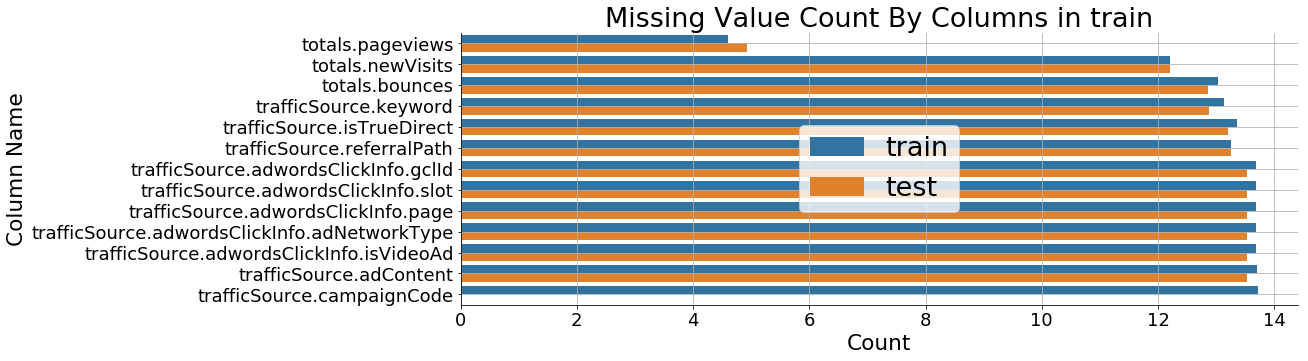

In [8]:
nan_sum_train = pd.DataFrame(train_df.isnull().sum().sort_values(), columns=['count'])
nan_sum_test = pd.DataFrame(test_df.isnull().sum().sort_values(), columns=['count'])
nan_sum_test = nan_sum_test[nan_sum_test['count'] > 0]
nan_sum_train = nan_sum_train[nan_sum_train['count'] > 0]
nan_sum_test['dataset'] = 'test'
nan_sum_train['dataset'] = 'train'
nan_sum = pd.concat([nan_sum_train, nan_sum_test])
nan_sum.reset_index(inplace=True)
nan_sum = nan_sum.sort_values(['count'])
nan_sum['count'] = np.log(nan_sum['count'])

plt.figure(figsize=(15, 5))
g = sns.barplot(data=nan_sum, hue='dataset', x='count', y='index')

plt.grid(True)
plt.xlabel("Count", fontsize=fontsize * 1.2)
plt.ylabel("Column Name", fontsize=fontsize * 1.2)
plt.title("Missing Value Count By Columns in train", fontsize=fontsize * 1.5)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize*1.5, loc=10)
sns.despine(top=True, right=True, left=False, bottom=False)

del nan_sum_train
del nan_sum_test
del nan_sum

/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


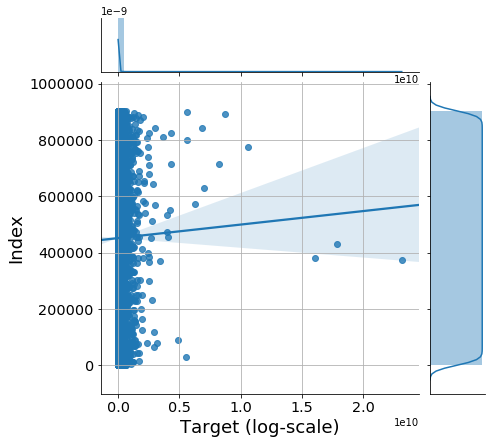

In [9]:
sns.jointplot(train_df['totals.transactionRevenue'], train_df.index,kind="regg")
# plt.title('', fontsize=fontsize * 1.5)
plt.xlabel('Target (log-scale)', fontsize=fontsize)
plt.ylabel('Index', fontsize=fontsize)
plt.xticks(fontsize=fontsize * 0.8)
plt.yticks(fontsize=fontsize * 0.8)
plt.grid(True)
sns.despine(top=True, right=True, left=False, bottom=False)

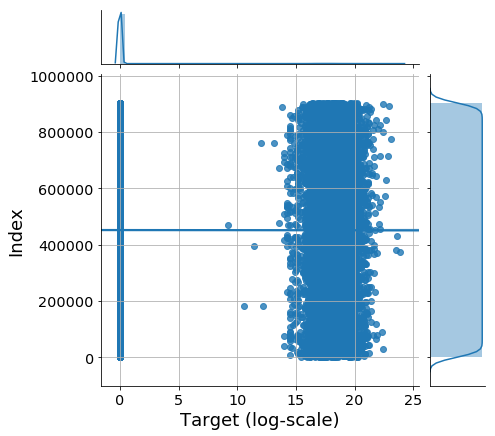

In [10]:
sns.jointplot(np.log(1 + train_df['totals.transactionRevenue']), train_df.index,kind="regg")
# plt.title('', fontsize=fontsize * 1.5)
plt.xlabel('Target (log-scale)', fontsize=fontsize)
plt.ylabel('Index', fontsize=fontsize)
plt.xticks(fontsize=fontsize * 0.8)
plt.yticks(fontsize=fontsize * 0.8)
plt.grid(True)
sns.despine(top=True, right=True, left=False, bottom=False)

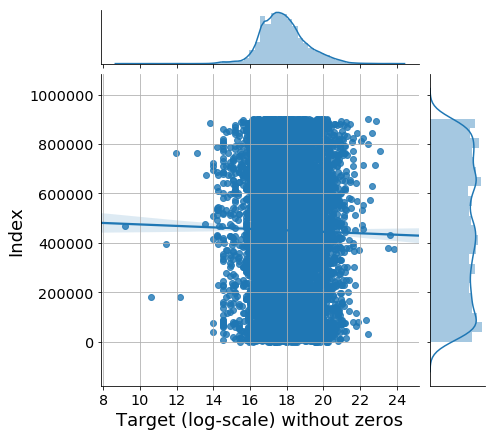

In [11]:
sns.jointplot(np.log(1+train_df[train_df['totals.transactionRevenue'] > 0]['totals.transactionRevenue']), train_df[train_df['totals.transactionRevenue'] > 0].index,kind="regg")
# plt.title('', fontsize=fontsize * 1.5)
plt.xlabel('Target (log-scale) without zeros', fontsize=fontsize)
plt.ylabel('Index', fontsize=fontsize)
plt.xticks(fontsize=fontsize * 0.8)
plt.yticks(fontsize=fontsize * 0.8)
plt.grid(True)
sns.despine(top=True, right=True, left=False, bottom=False);

**NOTICE: We should be classify zero and non-zero transaction. After that we can predict transaction value for non-zero calss**

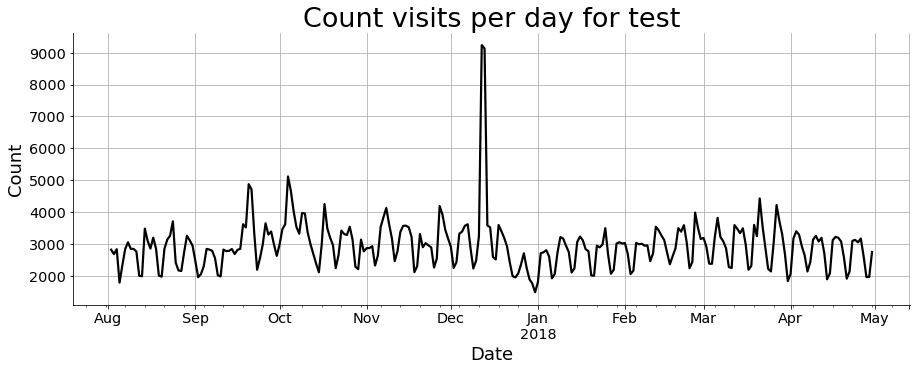

In [12]:
ax = test_df.groupby('date')['sessionId'].count().plot(figsize=(15, 5), color='k', linewidth=2.2)
plt.title('Count visits per day for test', fontsize=fontsize * 1.5)
plt.xlabel('Date', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.xticks(fontsize=fontsize * 0.8)
plt.yticks(fontsize=fontsize * 0.8)
plt.grid(True)
sns.despine(top=True, right=True, left=False, bottom=False)

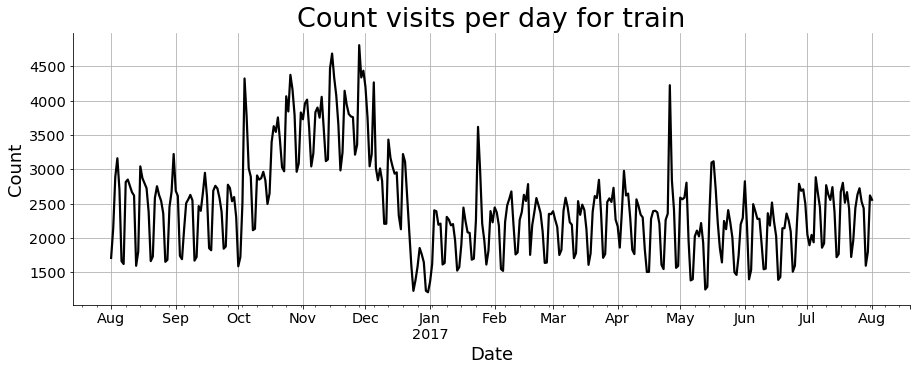

In [13]:
ax = train_df.groupby('date')['totals.transactionRevenue'].count().plot(figsize=(15, 5), color='k', linewidth=2.2)
plt.title('Count visits per day for train', fontsize=fontsize * 1.5)
plt.xlabel('Date', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.xticks(fontsize=fontsize * 0.8)
plt.yticks(fontsize=fontsize * 0.8)
plt.grid(True)
sns.despine(top=True, right=True, left=False, bottom=False)

**NOTICE: We can should be difference real value transaction and trend value transaction as distributions for train and test are differences**

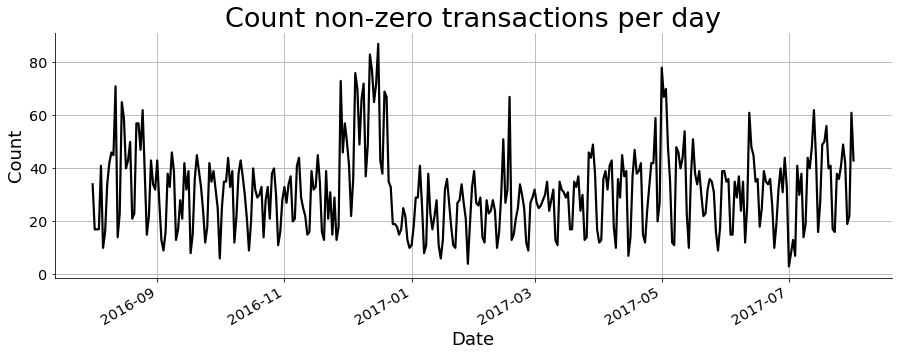

In [14]:
ax = train_df[train_df['totals.transactionRevenue'] > 0].groupby('date')['totals.transactionRevenue'].count().plot(figsize=(15, 5), color='k', linewidth=2.2)
plt.title('Count non-zero transactions per day', fontsize=fontsize * 1.5)
plt.xlabel('Date', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.xticks(fontsize=fontsize * 0.8)
plt.yticks(fontsize=fontsize * 0.8)
plt.grid(True)
sns.despine(top=True, right=True, left=False, bottom=False)

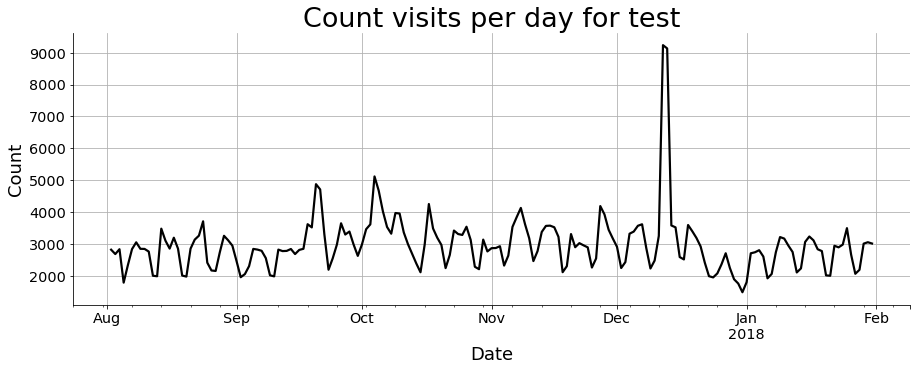

In [15]:
ax = test_df[test_df['date'] < pd.datetime(year=2018, month=2, day=1)].groupby('date')['sessionId'].count().plot(figsize=(15, 5), color='k', linewidth=2.2)
plt.title('Count visits per day for test', fontsize=fontsize * 1.5)
plt.xlabel('Date', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.xticks(fontsize=fontsize * 0.8)
plt.yticks(fontsize=fontsize * 0.8)
plt.grid(True)
sns.despine(top=True, right=True, left=False, bottom=False)

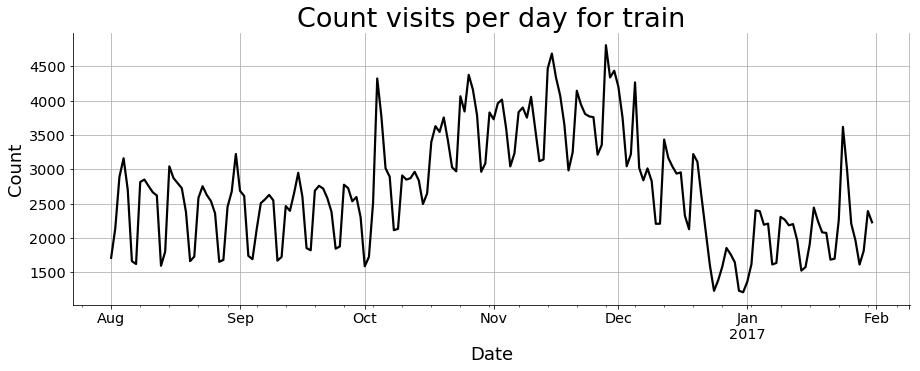

In [16]:
ax = train_df[train_df['date'] < pd.datetime(year=2017, month=2, day=1)].groupby('date')['sessionId'].count().plot(figsize=(15, 5), color='k', linewidth=2.2)
plt.title('Count visits per day for train', fontsize=fontsize * 1.5)
plt.xlabel('Date', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.xticks(fontsize=fontsize * 0.8)
plt.yticks(fontsize=fontsize * 0.8)
plt.grid(True)
sns.despine(top=True, right=True, left=False, bottom=False)

**NOTICE: Peoples visit a web-store the most often in the second day of week or the first day. Some weeks have 2-modal distribution.**

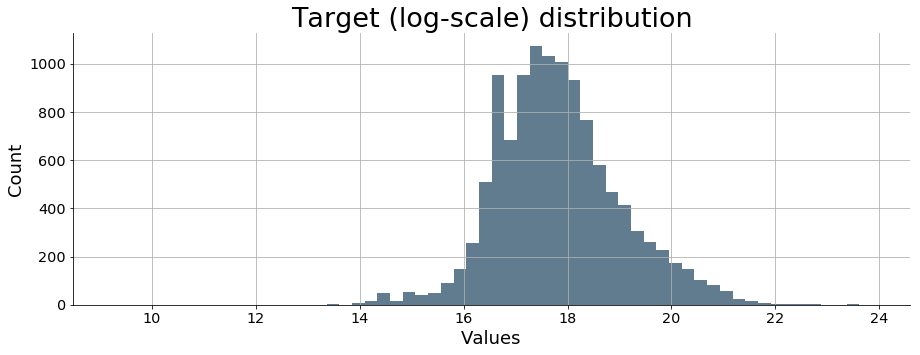

In [17]:
np.log(train_df[train_df['totals.transactionRevenue'] > 0]['totals.transactionRevenue']).plot.hist(figsize=(15,5), bins=60, color=sns.xkcd_rgb["blue grey"])
plt.title('Target (log-scale) distribution', fontsize=fontsize * 1.5)
plt.xlabel('Values', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.xticks(fontsize=fontsize * 0.8)
plt.yticks(fontsize=fontsize * 0.8)
plt.grid(True)
sns.despine(top=True, right=True, left=False, bottom=False)

**NOTICE: Left side of distribution is more mowed than right side.**

**NOTICE: If it takes different bins you will get some artifacts in the form of pits**

**NOTICE: sessionId has not trivial distribution**

# Baseline model (without Research)

In [15]:
train_df_ = train_df.copy(deep=True)
test_df_ = test_df.copy(deep=True)

#################
#################
#################

train_y = train_df_["totals.transactionRevenue"].values
train_id = train_df_["fullVisitorId"].values
test_id = test_df_["fullVisitorId"].values

#################
#################
#################

# label encode the categorical variables and convert the numerical variables to float
cat_cols = [
    "channelGrouping", "device.browser", 
    "device.deviceCategory", "device.operatingSystem", 
    "geoNetwork.city", "geoNetwork.continent", 
    "geoNetwork.country", "geoNetwork.metro",
    "geoNetwork.networkDomain", "geoNetwork.region", 
    "geoNetwork.subContinent", "trafficSource.adContent", 
    "trafficSource.adwordsClickInfo.adNetworkType", 
    "trafficSource.adwordsClickInfo.gclId", 
    "trafficSource.adwordsClickInfo.page", 
    "trafficSource.adwordsClickInfo.slot",
    "trafficSource.keyword", "trafficSource.medium", 
    "trafficSource.referralPath", "trafficSource.source",
    'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect'
]

#################
#################
#################

validation_date_threshold = pd.datetime(year=2017, month=5, day=31)

for col in cat_cols:
    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(train_df_[col].values.astype('str')) + list(test_df_[col].values.astype('str')))
    train_df_[col] = lbl.transform(list(train_df_[col].values.astype('str')))
    test_df_[col] = lbl.transform(list(test_df_[col].values.astype('str')))


channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


In [26]:
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df_[col] = train_df_[col].astype(float)
    test_df_[col] = test_df_[col].astype(float)

In [40]:
# Split the train dataset into development and valid based on time 
dev_df = train_df_[train_df_['date'] <= validation_date_threshold]
val_df = train_df_[train_df_['date'] > validation_date_threshold]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)
cl_dev_y = (dev_y != 0).astype(np.uint)
cl_val_y = (val_y != 0).astype(np.uint)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df_[cat_cols + num_cols] 

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
rf = RandomForestClassifier()
rf.fit(dev_X.fillna(0), cl_dev_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)k
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print('RMSE:', np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69597
[200]	valid_0's rmse: 1.69191
[300]	valid_0's rmse: 1.69105
Early stopping, best iteration is:
[290]	valid_0's rmse: 1.6907
RMSE: 1.7099839525986678


In [ ]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("../data/ga-customer-revenue-prediction/07.10.18_3.csv", index=False)

In [25]:
sub_df.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.080929
1,0000049363351866189,0.000000
2,0000053049821714864,0.000000
3,0000059488412965267,0.000000
4,0000085840370633780,0.015147


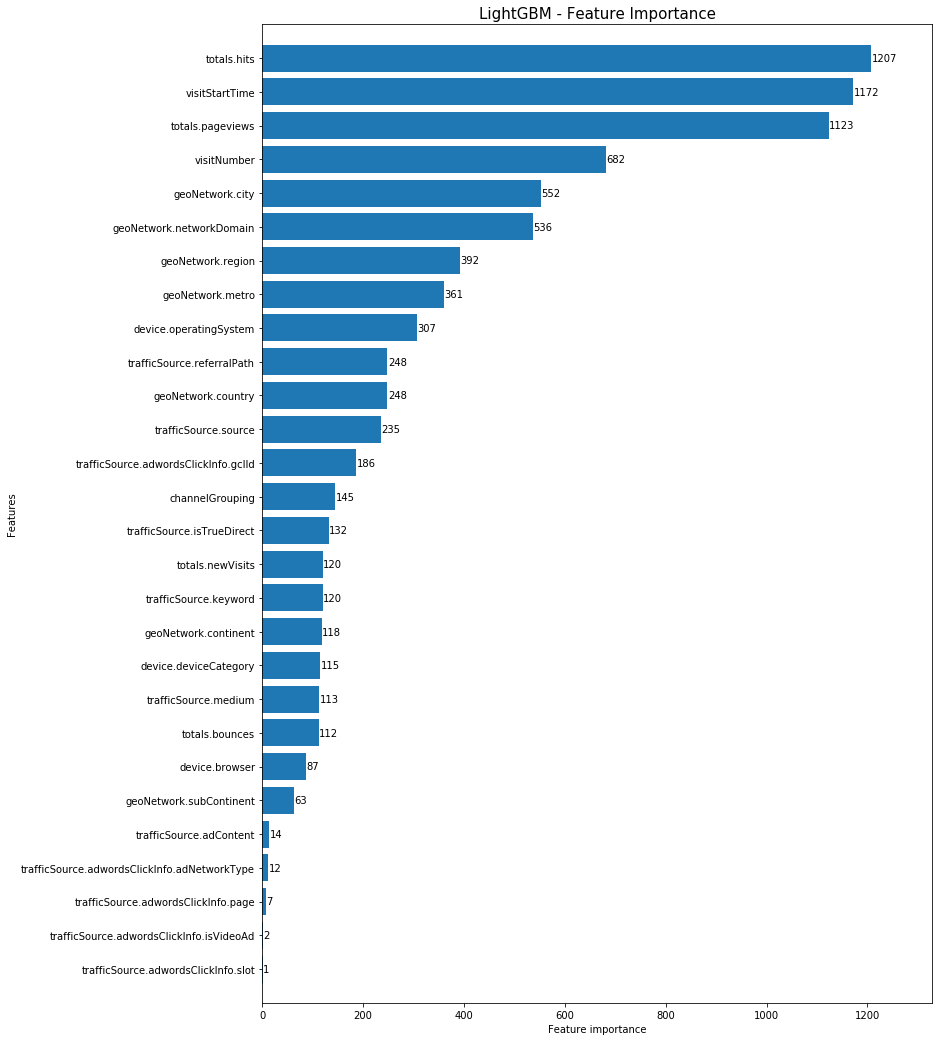

In [29]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()